# SNPlentiful - correlations with number of SNPs per gene

In [1]:
import gzip

import pandas
import numpy
import matplotlib.pyplot
import seaborn

%matplotlib inline

In [2]:
# Read gene connectivity degrees
degree_df = pandas.read_table('data/gene-degrees.tsv.gz')
degree_df.head(2)

,entrez_gene_id,symbol,node,metaedge,degree
0,1,A1BG,gene::1,gene < overexpression downregulation < gene,0
1,1,A1BG,gene::1,gene - participation - molecular function,0


In [3]:
# Read SNPs per Gene
columns = ['chromosome', 'chromosome_start', 'chromosome_end', 'entrez_gene_id', 'snps']

# Read SNPs per gene in the  Illumina HumanHap550 Platform
bed_hh550_df = pandas.read_table('data/hh550-entrez.bed', names=columns)
bed_hh550_df = bed_hh550_df[['entrez_gene_id', 'snps']].rename(columns={'snps': 'snps_hh550'})

# Read SNPs per gene in the Illumina HumanOmni1-Quad
bed_ho1_df = pandas.read_table('data/ho1-entrez.bed', names=columns)
bed_ho1_df = bed_ho1_df[['entrez_gene_id', 'snps']].rename(columns={'snps': 'snps_ho1'})

# Read SNPs per gene in the Affy 500k Array
bed_affy500_df = pandas.read_table('data/affy500-entrez.bed', names=columns)
bed_affy500_df = bed_affy500_df[['entrez_gene_id', 'snps']].rename(columns={'snps': 'snps_affy500'})

# Read SNPs per gene in ExAC
exac_df = pandas.read_table('data/exac-entrez.bed', names=columns)
exac_df = exac_df[['entrez_gene_id', 'snps']].rename(columns={'snps': 'snps_exac'})

snp_count_df = bed_hh550_df.merge(bed_ho1_df, how='outer').merge(bed_affy500_df, how='outer').merge(exac_df, how='outer')
snp_count_df.head(2)

,entrez_gene_id,snps_hh550,snps_ho1,snps_affy500,snps_exac
0,79501,0,0,0,4
1,148398,0,13,0,9


In [4]:
long_df = degree_df.merge(snp_count_df)
assert not any(long_df.duplicated(['entrez_gene_id', 'metaedge']))
for column in 'degree', 'snps_hh550', 'snps_ho1', 'snps_affy500', 'snps_exac':
    long_df['{}_log'.format(column)] = numpy.log10(1 + long_df[column])
with gzip.open('data/combined.tsv.gz', 'wt') as write_file:
    long_df.to_csv(write_file, index=False, sep='\t')
long_df.head(2)

,entrez_gene_id,symbol,node,metaedge,degree,snps_hh550,snps_ho1,snps_affy500,snps_exac,degree_log,snps_hh550_log,snps_ho1_log,snps_affy500_log,snps_exac_log
0,1,A1BG,gene::1,gene < overexpression downregulation < gene,0,4,12,1,6,0,0.69897,1.113943,0.30103,0.845098
1,1,A1BG,gene::1,gene - participation - molecular function,0,4,12,1,6,0,0.69897,1.113943,0.30103,0.845098


## Visualization

In [5]:
long_df = pandas.read_table('data/combined.tsv.gz')

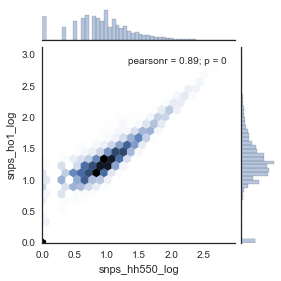

In [6]:
with seaborn.axes_style('white'):
    grid = seaborn.jointplot(x='snps_hh550_log', y='snps_ho1_log', data=long_df, kind='hex', gridsize=25, size=4)

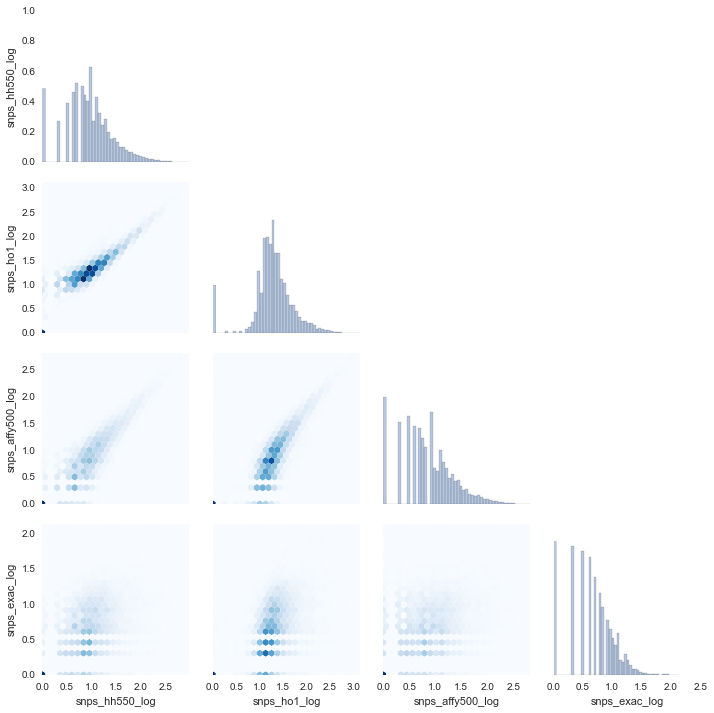

In [7]:
plot_df = long_df.dropna().drop_duplicates('entrez_gene_id')
seaborn.set_style('white')
grid = seaborn.PairGrid(plot_df, vars=['snps_hh550_log', 'snps_ho1_log', 'snps_affy500_log', 'snps_exac_log'])
grid.map_diag(seaborn.distplot, kde=False)
grid.map_lower(matplotlib.pyplot.hexbin, cmap='Blues', gridsize=25, linewidths=0)
seaborn.despine(top=True, right=True, left=True, bottom=True)

In [8]:
log_to_degree = lambda x: 10**x - 1